# Resample a DES cluster lensing chain with seven parameters

In this example, we will read in a DES Year 1 cluster weak lensing chain with six parameters ($\log_{10}M$,$c$,$\tau$,$f_{\rm mis}$,$A_M$,$B_0$,$R_s$) and build an importance sampler for it. We will then resample it and try to recover (essentially) the exact same chain.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
Npoints = 16*5000
input_chain = np.loadtxt("chain_full_Y1_SAC_z0_l6.orientation_v4")[-Npoints:]
lnpost = np.loadtxt("likes_full_Y1_SAC_z0_l6.orientation_v4")[-Npoints:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)

('chain shape is  ', (80000, 7))
('lnpost shape is ', (80000,))


In [4]:
#Pick out training points
N_training = 300
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

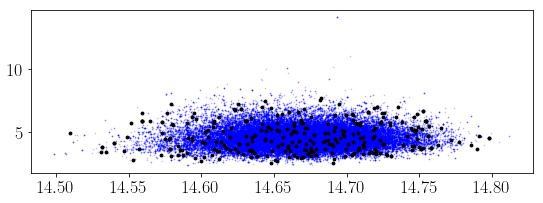

In [5]:
#Visualize the training points selected against the chain
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,3))
plt.subplots_adjust(wspace=0.6)
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)

points,_ = IS.get_training_data()
ax.scatter(points[:,0], points[:,1], c='k', s=8)

In [6]:
#Train the GP inside of the sampler
IS.train()

In [7]:
#Resample the chain with an MCMC
means = np.mean(input_chain, 0)

nwalkers = 16
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)

print("Running first burn-in")
p0 = np.array([means + means*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


In [8]:
test_chain = sampler.flatchain
print("Means and stds of input chain: ", np.mean(input_chain, 0), np.std(input_chain, 0))
print("Means and stds of test chain:  ", np.mean(test_chain, 0), np.std(test_chain, 0))

('Means and stds of input chain: ', array([14.66820635,  4.56244187,  0.17590166,  0.25028157,  1.02027052,
        0.23288549,  1.36107954]), array([0.03857072, 0.79997258, 0.0396994 , 0.07729367, 0.02515939,
       0.02878557, 0.2008262 ]))
('Means and stds of test chain:  ', array([14.66721275,  4.52097232,  0.17559908,  0.24294839,  1.02058452,
        0.23368675,  1.36019766]), array([0.03661219, 0.79281221, 0.03994515, 0.0787573 , 0.02510217,
       0.02818713, 0.20425635]))


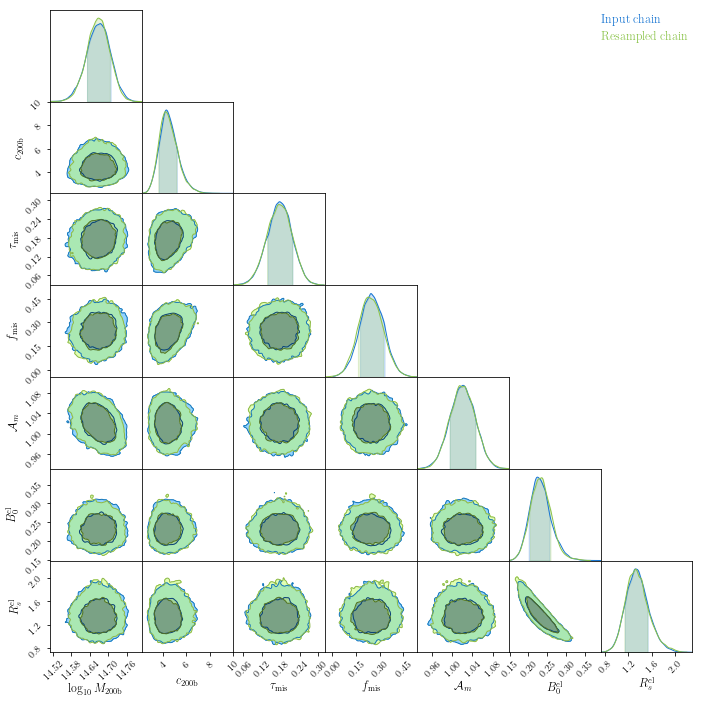

In [9]:
c = CC.ChainConsumer()

labels = [r"$\log_{10}M_{\rm 200b}$", r"$c_{\rm 200b}$", r"$\tau_{\rm mis}$", r"$f_{\rm mis}$", "$\mathcal{A}_m$",
          r"$B_0^{\rm cl}$", r"$R_s^{\rm cl}$"]

c.add_chain(input_chain, parameters=labels, name="Input chain")
c.add_chain(test_chain, parameters=labels, name="Resampled chain")

fig = c.plotter.plot()
#fig.savefig("full_7D_cluster_lensing_example.png", dpi=300, bbox_inches="tight")